<a href="https://colab.research.google.com/github/tom919654/handson/blob/gh-pages/ch_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import fetch_openml

#using mnist dataset
mnist = fetch_openml('mnist_784', version = 1) 
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
import tensorflow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10741316460875846939
]


In [3]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

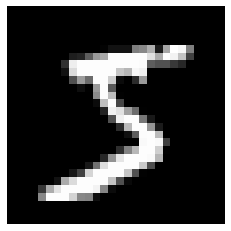

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

#image is 28*28 pixel & 0(w) ~ 255(b)

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = 'gray') # cmap = 'binary' is same as cmap=mpl.cm.binary
plt.axis('off')
plt.show()

In [6]:
y[0]
#some_digit

'5'

In [7]:
import numpy as np

y = y.astype(np.uint8)

In [8]:
def plot_digit(data):
  image = data.reshape(28,28)
  plt.imshow(image, cmap = mpl.cm.binary, interploation = 'nearest')
  plt.axis('off')

In [9]:
def plot_digits(instances, images_per_row =10, **options):
  size = 28
  images_per_row = min(len(instances), images_per_row)
  images = [instance.reshape(size,size) for instance in instances]
  n_rows = (len(instances) - 1) // images_per_row +1 #// with integer
  row_images= []
  n_empty = n_rows * images_per_row - len(instances)
  images.append(np.zeros((size, size*n_empty)))
  for row in range(n_rows):
    rimages = images[row*images_per_row : (row+1) * images_per_row]
    row_images.append(np.concatenate(rimages, axis = 1))
  image = np.concatenate(row_images,axis=0)
  plt.imshow(image,cmap = mpl.cm.binary, **options)
  plt.axis('off')

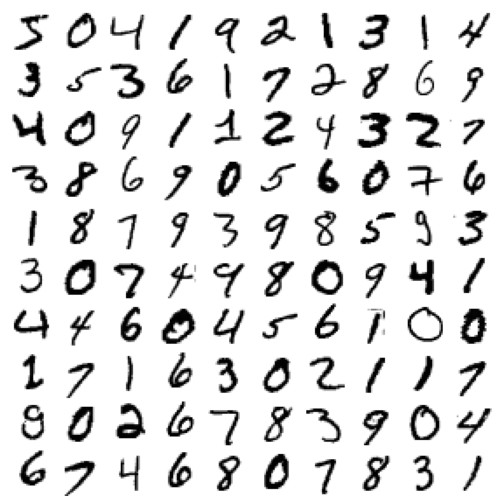

In [10]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row = 10)
plt.show()

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

binary classifier

In [13]:
#binary classifier with SGD

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [14]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [15]:
#stdchastic Gradient Descent
from sklearn.linear_model import SGDClassifier

#sgd_clf is estimator
sgd_clf = SGDClassifier(max_iter=1000, tol= 1e-3, random_state=42) #max_iteration == 최대 반복횟수
#making a model
#fit method : X training data, y : target values
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

In [16]:
sgd_clf.predict([some_digit]) #2nd dimension matrix is required

array([ True])

In [17]:
#cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

#split 3 times

skfolds = StratifiedKFold(n_splits=3, random_state = 42, shuffle = True)
#cross_val_score(sgd_clk, X_train, y_train_5, cv=skfolds)

#split method : generate indices to split data into training and test set.
for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf) #Constructs a new unfitted estimator with the same parameters. Clone does a deep copy of the model in an estimator without actually copying attached data. It yields a new estimator with the same parameters that has not been fitted on any data.
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]


  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [18]:
skfolds.split(X_train, y_train_5)

<generator object _BaseKFold.split at 0x0000027517368BA0>

cross validation은 데이터셋을 쪼개서 돌아가면서 test, train셋으로 바꿈. 그래서 한번씩 test에 이용되게 됨. 즉 적은 데이터로 최대한 많은 학습을 해보고 테스트 할 수 있다.

https://scikit-learn.org/stable/modules/cross_validation.html?highlight=stratifiedkfold

In [19]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html?highlight=cross_val_score#sklearn.model_selection.cross_val_score

In [20]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1), dtype=bool) #zeros : all negative

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

다 5가 아니다라고만 해도 90%넘는 정확도임. 결국 교차검증은 여기서 성능 평가하기엔 부적합

In [22]:
#using confusion matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

 - TN = 53892 : non-5 -> non-5 & correctly classified
 - FP = 687 : non-5 -> 5 & uncorrectly classified
 - FN = 1891 : 5 -> non-5 & uncorrectly classified
 - TP = 3530 : 5 -> 5 & correctly classified

 - precision : TP / (TP + FP)  5라고 인식한 것 중에 맞을 확률
 - recall : TP / (TP + FN) 실제로 5인 것 중에 맞춘 확률


- TN FP
- FN TP

In [24]:
#not important
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [25]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 3530 / (687 + 3530)

0.8370879772350012

In [26]:
recall_score(y_train_5, y_train_pred) # == 3530 / (1891 + 3530)

0.6511713705958311

In [27]:
# make F1_score as harmonic means of precisoin & recall
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

양자역학에서 불확정성 원리같이 precision 과 recall 은 trade-off한 relationship을 갖고 있음

In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [29]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [30]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = 'decision_function')

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [33]:
cd C:\Users\김유경\Desktop\jupyter

C:\Users\김유경\Desktop\jupyter


In [34]:
ls 

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 02DB-A664

 C:\Users\김유경\Desktop\jupyter 디렉터리

2021-01-28  오후 08:04    <DIR>          .
2021-01-28  오후 08:04    <DIR>          ..
2021-01-28  오후 06:09    <DIR>          .ipynb_checkpoints
2016-10-24  오후 04:12         4,691,820 NanumGothic.ttf
2021-01-28  오후 06:06                72 test.py.ipynb
2021-01-28  오후 06:11               288 Untitled.ipynb
2021-01-28  오후 08:00               120 로컬 런타임용.txt
               4개 파일           4,692,300 바이트
               3개 디렉터리  927,493,414,912 바이트 남음


In [35]:
#한글 폰트
import matplotlib.font_manager as fm

path = 'NanumGothic.ttf'
fontprop = fm.FontProperties(fname = path, size = 18)

In [36]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision')
  plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
  plt.legend(loc = 'center right', fontsize = 16)
  plt.xlabel('임계값', fontproperties=fontprop)
  plt.grid(True)
  plt.axis([-50000, 50000, 0 ,1])

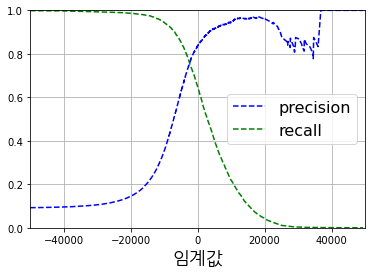

In [37]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [38]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [39]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [40]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [41]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [42]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [43]:
# cd /content/drive/MyDrive/font/

In [44]:
# !ls

In [45]:
# #한글 폰트
# import matplotlib.font_manager as fm

# path = 'NanumBarunGothic.ttf'
# fontprop = fm.FontProperties(fname = path, size = 18)

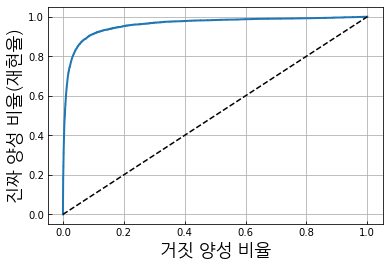

In [46]:
def plot_roc_curve(fpr, tpr, label = None):
  plt.plot(fpr, tpr, linewidth = 2, label = label)
  plt.plot([0,1],[0,1], 'k--')
  plt.xlabel('거짓 양성 비율',fontproperties=fontprop)
  plt.ylabel('진짜 양성 비율(재현율)',fontproperties=fontprop)
  plt.grid(1)
  plt.tick_params(axis='both', direction = 'in')

plot_roc_curve(fpr,tpr)
plt.show()

In [47]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [48]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [49]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

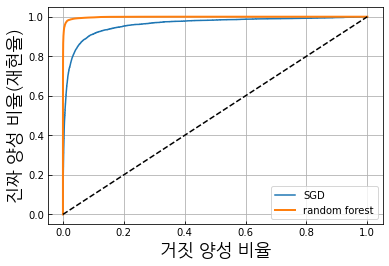

In [50]:
plt.plot(fpr,tpr, label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'random forest')
plt.legend(loc = 'lower right')
plt.show()

In [51]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

OvR : n개 모델 훈련, liblinear 이용하는 LinearSVC/LogisticRegression클래스
OvO : n(n-1)/2 개 훈련, libsvm 사용하는 SVC클래스
Multinomail : SGDClassifier, LogisticRegression, RandomForestClassifier

In [52]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [53]:
np.argmax(some_digit_scores)

5

In [54]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [55]:
svm_clf.classes_[5]

5

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma= 'auto', random_state = 42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

In [ ]:
len(vor_clf.estimators_)

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

In [ ]:
sgd_clf.decision_function([some_digit])

In [ ]:
cross_val_score(sogd_clf, X_train, y_train, cv=3, scoring ='accuracy')

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

In [60]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

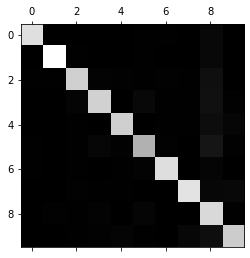

In [61]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [62]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

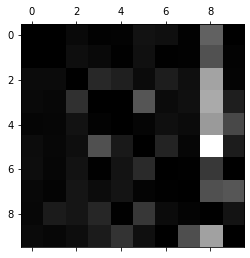

In [63]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

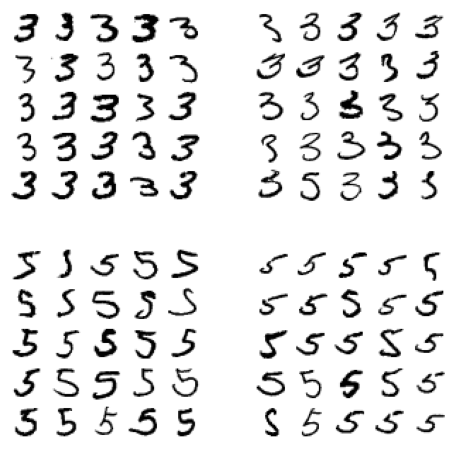

In [67]:
cl_a, cl_b = 3,5
X_aa = X_train[(y_train==cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize = (8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)

In [71]:
#다중 레이블 분류

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [72]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_trai_knn_pred, average = 'macro')

In [ ]:
noise = np.random.randint(0,199,(len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)